## Homework 6, Problem 3 on Wiener filter

ECE C143A/C243A, Spring Quarter 2022, Prof. J.C. Kao, TAs T. Monsoor and W. Yu

Total: 15 points. In this notebook, you will implement an optimal linear estimator decoder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math
import nsp as nsp
# Load matplotlib images inline
%matplotlib inline
# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2
data = sio.loadmat('JR_2015-12-04_truncated2.mat') # load the .mat file.
R = data['R'][0,:]

### (a) (4 points) Preparing training data for a Wiener filter.  [Code solution provided; please understand it and answer the question.]

Now that we’ve built an optimal linear estimator, we’ll extend it to incorporate history. We will train a Wiener filter, again using just the first 400 trials of the R-struct. We will use 100 ms worth of history in our Wiener filter. As each bin is 25 ms long, this corresponds to using data up to and including 4 bins in the past, i.e. $P=3$. Make the large matrix $Y_W$ discussed in Lecture. To be clear, we are talking about the matrix:
\begin{bmatrix}
    y_{P+1}       & y_{P+2} & y_{P+3} & \dots & y_{K} \\
    y_{P}       & y_{P+1} & y_{P+2} & \dots & y_{K-1} \\
    \dots \\
    y_{1}       & y_{2} & y_{3} & \dots & y_{K-P}\\
    1       & 1 & 1 & \dots & 1\\
\end{bmatrix}
Calculate this matrix and output its dimension.

In [2]:
#====================================================#
# YOUR CODE HERE:
#   Create the Y_W matrix and print its dimensions.
#====================================================#
dt = 25
train_num = 400
Y =scipy.sparse.hstack(R[0:train_num]['spikeRaster'])
X =scipy.sparse.hstack(R[0:train_num]['cursorPos'])
X= scipy.sparse.csc_matrix(X)
Y_bin = nsp.bin(Y, dt,'sum')

X_bin = nsp.bin(X, dt,'first')
X_bin = np.diff(X_bin[0:2,:])/dt*1000

X_small_bin = np.matrix(X_bin[:,3:],dtype=float)
last_index = np.size(X_bin,1)
Y1= np.matrix(Y_bin[:,3:],dtype= float)
Y2 =np.matrix(Y_bin[:,2:-1],dtype= float)
Y3 =np.matrix(Y_bin[:,1:-2],dtype= float)
Y4 =np.matrix(Y_bin[:,0:-3],dtype= float)
Y_large = np.vstack((Y1,Y2,Y3,Y4))

Y_w_bin = np.vstack((Y_large,np.ones(np.size(Y_large,1))))

print("The dimension for the large matrix",np.size(Y_w_bin,0),np.size(Y_w_bin,1))
#====================================================#
# END YOUR CODE
#====================================================#   

The dimension for the large matrix 385 16462


Question: What are the dimensions of $Y_W$?

Answer: 385 x 16462

### (b) (7 points)  Fit a Wiener filter and decode activity.

Fit the Wiener filter using the data matrix you generated in part(a). Plot, as you did in question 2(g), the decoded trajectories for each test trial. (Hint: to decode the first 3 velocities of trial i at times 25 ms, 50 ms, and 75 ms, since 100 ms have not yet occurred in the trial, you will have to use the last bins of spiking activity in trial $i−1$.)


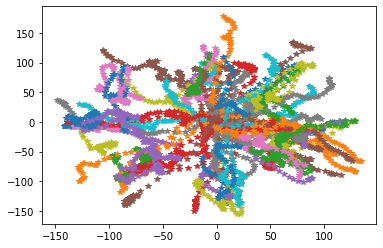

In [3]:
#====================================================#
# YOUR CODE HERE:
#   Fit the Wiener filter and decode the trajectories for
#   each test trial.
#====================================================#
dt = 25
Y_pseudo = scipy.linalg.pinv(Y_w_bin.astype(float))
L = np.matmul(X_small_bin, Y_pseudo)
for trial in range(400, 506, 1):
    Y = R[trial]['spikeRaster']
    X = R[trial]['cursorPos']
    
    Y_bin = nsp.bin(Y, dt,'sum')

    Y1= np.matrix(Y_bin[:,3:],dtype= float)
    Y2 =np.matrix(Y_bin[:,2:-1],dtype= float)
    Y3 =np.matrix(Y_bin[:,1:-2],dtype= float)
    Y4 =np.matrix(Y_bin[:,0:-3],dtype= float)
    Y_large = np.vstack((Y1,Y2,Y3,Y4))

    Y_w_bin_0 = np.vstack((Y_large,np.ones(np.size(Y_large,1))))

    rates = np.matmul(L,Y_w_bin_0)
    step = np.cumsum(rates, axis = 1)*dt/1000
    step = np.swapaxes(step, 0, 1)
    step[:,0] += X[0,0]
    step[:,1] += X[1,0]
    plt.plot(step[:,0], step[:,1], '*')
    


#====================================================#
# END YOUR CODE
#====================================================#   

### (c) (4 points) Calculate the mean-square error for the Wiener filter.

What is the average mean-square error in position per trial? Did the Wiener filter perform better or worse than the optimal linear estimator?

In [7]:
#====================================================#
# YOUR CODE HERE:
#   Calculate the mean-squared error between the decoded
#   hand position and the true hand position.  Average
#   the squared errors across time; then average the squared
#   errors across trials.
#====================================================#
cum_dis = 0
for trial in range(400, 506, 1):
    Y = R[trial]['spikeRaster']
    X = R[trial]['cursorPos']
    dist = np.zeros(X.shape[1])
    
    Y_bin = nsp.bin(Y, dt,'sum')

    Y1= np.matrix(Y_bin[:,3:],dtype= float)
    Y2 =np.matrix(Y_bin[:,2:-1],dtype= float)
    Y3 =np.matrix(Y_bin[:,1:-2],dtype= float)
    Y4 =np.matrix(Y_bin[:,0:-3],dtype= float)
    Y_large = np.vstack((Y1,Y2,Y3,Y4))
    Y_w_bin_0 = np.vstack((Y_large,np.ones(np.size(Y_large,1))))

    rates = np.matmul(L,Y_w_bin_0)
    step = np.cumsum(rates, axis = 1)*dt/1000
    step = np.swapaxes(step, 0, 1)
    step[:,0] += X[0,0]
    step[:,1] += X[1,0]
    
    
    
    moves = np.arange(0,X.shape[1],dt)
    real_pos = X[0:2,:][:, moves]
    real_pos = np.swapaxes(real_pos, 0, 1)
    dist = np.zeros(X.shape[1])
    for i in range(len(real_pos)-4):
        dist[i] = (real_pos[i,0] - step[i,0])**2 + (real_pos[i,1] - step[i,1])**2
        
    
    mse = np.sum(dist)/(len(real_pos)-4)
    cum_dis += mse
print(f'Mean square error is {cum_dis/ 106}mm^2') 


#====================================================#
# END YOUR CODE
#====================================================#  

Mean square error is 3240.8007003265834mm^2


Question: Does the WF do better or worse than the OLE?

Answer: It performs better as it has a smaller MSE